In [82]:
import real_estate_api as rea

from typing import Union, List
from types import ModuleType
from beartype._decor.decormain import beartype
import warnings

import numpy as np
import pandas as pd
import sys
import importlib

from collections import defaultdict
from itertools import chain
import random

from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import keys as k
keys = k.getKeys()

In [2]:
user_home = rea.get_UserHome(keys['SampleHouse'].strip("\'"))
hoi = rea.get_HousesOfInterest(user_home, n=2000, listed_to_sold_ratio=0.3, verbose=True)
gd = rea.geo_data(hoi['geo'])

Shortfall in listed houses detected, appending 114 of current listing to results.


In [3]:
# Can this be the first step in the pipeline or no?
fg = rea.FeatureGenerator(
    houses = hoi['houses'], 
    gd=gd,
    user_home=user_home
)

In [4]:
class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X).drop_duplicates(subset=['Property_ID'])

pipe = Pipeline([
    ('format_data', ToDataFrame())
])

output = pipe.fit_transform(fg.features, fg.targets)
output

,Property_ID,Status,Days_listed,Days_updated,baths_full,baths_3qtr,baths_half,baths_1qtr,year_built,lot_sqft,sqft,garage,stories,beds,tags,new_construction,distance_to_home,lat,long
0,2659298958,for_sale,2,2,1,1,0,0,1979,6500,1660,1,1,5,"[community_outdoor_space, den_or_office, dinin...",False,10.862586,47.729440,-122.324938
1,1093027260,for_sale,3,3,2,1,1,0,2012,1975,1780,1,1,3,"[city_view, dining_room, dishwasher, energy_ef...",False,1.047090,47.587612,-122.309678
2,1648537949,for_sale,3,3,2,0,0,0,1962,7618,3310,2,1,6,"[community_outdoor_space, dining_room, family_...",False,0.179029,47.574457,-122.303656
3,1757015623,for_sale,3,3,3,2,0,0,1911,3376,2800,0,1,5,"[dining_room, forced_air, hardwood_floors, oce...",False,6.660062,47.660596,-122.365015
4,1776112231,for_sale,3,3,3,0,1,0,2017,3774,3220,2,1,4,"[community_outdoor_space, community_security_f...",False,8.236843,47.687443,-122.354342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,1627256650,sold,0,130,1,1,1,0,1928,4452,2470,0,1,3,"[central_air, city_view, community_outdoor_spa...",False,3.265067,47.570625,-122.376388
1745,1311822489,sold,0,130,3,0,0,0,1953,8037,3610,2,1,4,"[carport, central_air, community_outdoor_space...",False,6.987278,47.671516,-122.274560
1746,2102420682,sold,0,130,1,1,0,0,1947,6395,2284,0,1,3,"[community_outdoor_space, den_or_office, dinin...",False,4.747036,47.537290,-122.393758
1747,2141376707,sold,0,126,1,1,1,0,1945,5000,2380,1,1,4,"[community_clubhouse, community_gym, community...",False,6.023588,47.658938,-122.287651


In [5]:
to_data_frame = ToDataFrame()
X_t = to_data_frame.fit_transform(fg.features)
X_t

,Property_ID,Status,Days_listed,Days_updated,baths_full,baths_3qtr,baths_half,baths_1qtr,year_built,lot_sqft,sqft,garage,stories,beds,tags,new_construction,distance_to_home,lat,long
0,2659298958,for_sale,2,2,1,1,0,0,1979,6500,1660,1,1,5,"[community_outdoor_space, den_or_office, dinin...",False,10.862586,47.729440,-122.324938
1,1093027260,for_sale,3,3,2,1,1,0,2012,1975,1780,1,1,3,"[city_view, dining_room, dishwasher, energy_ef...",False,1.047090,47.587612,-122.309678
2,1648537949,for_sale,3,3,2,0,0,0,1962,7618,3310,2,1,6,"[community_outdoor_space, dining_room, family_...",False,0.179029,47.574457,-122.303656
3,1757015623,for_sale,3,3,3,2,0,0,1911,3376,2800,0,1,5,"[dining_room, forced_air, hardwood_floors, oce...",False,6.660062,47.660596,-122.365015
4,1776112231,for_sale,3,3,3,0,1,0,2017,3774,3220,2,1,4,"[community_outdoor_space, community_security_f...",False,8.236843,47.687443,-122.354342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,1627256650,sold,0,130,1,1,1,0,1928,4452,2470,0,1,3,"[central_air, city_view, community_outdoor_spa...",False,3.265067,47.570625,-122.376388
1745,1311822489,sold,0,130,3,0,0,0,1953,8037,3610,2,1,4,"[carport, central_air, community_outdoor_space...",False,6.987278,47.671516,-122.274560
1746,2102420682,sold,0,130,1,1,0,0,1947,6395,2284,0,1,3,"[community_outdoor_space, den_or_office, dinin...",False,4.747036,47.537290,-122.393758
1747,2141376707,sold,0,126,1,1,1,0,1945,5000,2380,1,1,4,"[community_clubhouse, community_gym, community...",False,6.023588,47.658938,-122.287651


In [6]:
X_t[X_t['lot_sqft'] > 5_000].sort_values('lot_sqft')

,Property_ID,Status,Days_listed,Days_updated,baths_full,baths_3qtr,baths_half,baths_1qtr,year_built,lot_sqft,sqft,garage,stories,beds,tags,new_construction,distance_to_home,lat,long
245,2053584107,for_sale,73,13,3,0,1,0,1990,5001,3190,2,1,5,"[community_outdoor_space, den_or_office, dinin...",False,8.190595,47.671650,-122.403238
1009,2105562210,sold,0,74,2,0,1,0,2004,5001,2320,2,1,4,"[community_outdoor_space, dishwasher, fireplac...",False,2.319373,47.542269,-122.285004
470,1272254281,sold,0,0,3,1,0,0,1995,5002,1590,0,1,4,[],False,3.386088,47.537104,-122.356479
483,1481863835,sold,0,17,1,1,0,0,1950,5002,2150,1,1,4,"[community_outdoor_space, dining_room, dishwas...",False,3.746594,47.529273,-122.354735
1066,1205839094,sold,0,0,4,1,0,0,2013,5002,3040,0,2,4,[],False,2.768258,47.554462,-122.359338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,1957335960,sold,0,69,1,1,0,0,1953,14420,3120,1,1,2,"[dishwasher, fireplace, forced_air, washer_dry...",False,3.487642,47.531030,-122.263869
424,1501838381,for_sale,305,12,2,1,1,0,1917,14555,2460,0,1,3,"[forced_air, hardwood_floors, lake_view, recre...",False,3.718301,47.522918,-122.275616
1078,2545882768,sold,0,80,2,0,1,0,1958,14556,3500,2,1,5,"[community_outdoor_space, dining_room, dishwas...",False,5.394379,47.507509,-122.370338
500,9227231551,sold,0,0,2,0,1,0,1941,14809,2190,0,1,3,[],False,10.197545,47.718999,-122.335466


In [7]:
# Add more info into this for testing and observation, drop in the pipeline.
X_t['target'] = fg.targets
X_t[X_t['target'] < 300_000]

,Property_ID,Status,Days_listed,Days_updated,baths_full,baths_3qtr,baths_half,baths_1qtr,year_built,lot_sqft,sqft,garage,stories,beds,tags,new_construction,distance_to_home,lat,long,target
477,1834714746,sold,0,0,1,0,0,0,1926,7620,510,0,1,1,[],False,4.115228,47.518466,-122.343261,289000
539,1607868914,sold,0,0,1,0,0,0,1949,7336,720,0,1,2,[],False,5.171223,47.497802,-122.301069,250000
578,2736582745,sold,0,0,1,0,0,0,1929,1500,950,0,1,3,[],False,3.596260,47.528468,-122.347314,167691
673,2787478057,sold,0,0,1,0,0,0,1912,8604,770,0,1,2,[],False,3.319479,47.529410,-122.275107,250000
677,2084677018,sold,0,0,1,0,0,0,1911,3072,760,0,1,2,[],False,0.325629,47.577307,-122.307035,250000
886,1291698360,sold,0,0,1,1,0,0,1946,6300,770,0,1,2,[],False,8.370736,47.690063,-122.350963,170000
1143,1543568532,sold,0,0,1,0,1,0,1947,4800,1190,0,1,3,[],False,0.579140,47.567614,-122.316341,197009
1440,1947257373,sold,0,0,1,0,0,0,1958,7186,1240,0,1,3,[],False,5.365929,47.501509,-122.352823,220000
1535,9866765359,sold,0,115,1,0,0,0,1996,560,480,0,1,1,"[city_view, community_outdoor_space, community...",False,4.687913,47.636698,-122.339622,285000
1724,2167256605,sold,0,0,1,1,0,0,2000,5183,1250,0,2,1,[],False,3.636257,47.584625,-122.382371,160000


In [8]:
fg.houses[727].features

{'Property_ID': '1292592743',
 'Status': 'sold',
 'Days_listed': 0,
 'Days_updated': 0,
 'baths_full': 7,
 'baths_3qtr': 3,
 'baths_half': 2,
 'baths_1qtr': 0,
 'year_built': 2021,
 'lot_sqft': 4130,
 'sqft': 4695,
 'garage': 0,
 'stories': 3,
 'beds': 7,
 'tags': [],
 'new_construction': False,
 'distance_to_home': 8.49897052173735,
 'lat': 47.691874,
 'long': -122.351579}

In [9]:
from sklearn.preprocessing import StandardScaler

# This will randomly take 10% of the data as a validation set.
test_indicies = random.sample(range(0, len(fg.targets)), int(0.1 * len(fg.targets)))
train_indicies = set(range(0, len(fg.targets))).difference(set(test_indicies))

target_transformer = StandardScaler()
train_targets = target_transformer.fit_transform(np.array(list(map(fg.targets.__getitem__, train_indicies))).reshape(-1,1))
test_targets = target_transformer.transform(np.array(list(map(fg.targets.__getitem__, test_indicies))).reshape(-1,1))

train_features = list(map(fg.features.__getitem__, train_indicies))
test_features = list(map(fg.features.__getitem__, test_indicies))

In [10]:
ToDataFrame().fit_transform(train_features).head()

,Property_ID,Status,Days_listed,Days_updated,baths_full,baths_3qtr,baths_half,baths_1qtr,year_built,lot_sqft,sqft,garage,stories,beds,tags,new_construction,distance_to_home,lat,long
0,2659298958,for_sale,2,2,1,1,0,0,1979,6500,1660,1,1,5,"[community_outdoor_space, den_or_office, dinin...",False,10.862586,47.729440,-122.324938
1,1093027260,for_sale,3,3,2,1,1,0,2012,1975,1780,1,1,3,"[city_view, dining_room, dishwasher, energy_ef...",False,1.047090,47.587612,-122.309678
2,1648537949,for_sale,3,3,2,0,0,0,1962,7618,3310,2,1,6,"[community_outdoor_space, dining_room, family_...",False,0.179029,47.574457,-122.303656
3,1757015623,for_sale,3,3,3,2,0,0,1911,3376,2800,0,1,5,"[dining_room, forced_air, hardwood_floors, oce...",False,6.660062,47.660596,-122.365015
4,1776112231,for_sale,3,3,3,0,1,0,2017,3774,3220,2,1,4,"[community_outdoor_space, community_security_f...",False,8.236843,47.687443,-122.354342


In [32]:
'''
Days Listed - Linear
Days Updated - Linear
*baths - Normalize
year_built - I want to bucketize these, then keep the dummies.
lot_sqft - Normalize
    Feature generation, multiply lot_sqft normalized and the inverse_distance
        More questions, can you do this?
sqft - Normalize
garage / stories / beds - Normalize
Tags - Do what we did in the nlp homework
'''

from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

from collections import Counter

class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X).drop_duplicates(subset=['Property_ID'])

class DictEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tags_to_keep = None

    def fit(self, X, y=None):
        tag_frequency = Counter(chain(*X))
        self.tags_to_keep = [k for k, v in tag_frequency.items() if v > 1]
        return self
    
    def transform(self, X):
        return pd.Series(map(lambda l : {k : 1 for k in l if l in self.tags_to_keep}, X))

# We need to impute the lat and long

minmax_cols = ['distance_to_home'] # 'Days_listed', 'Days_listed', 
normalize_cols = ['lot_sqft', 'sqft']
bucketize_cols = ['year_built']
lat_long_cols = ['lat', 'long']
dummy_cols = ['baths_full', 'baths_full', 'baths_full', 'baths_1qtr', 'garage', 'stories', 'beds']

preprocess_min_max_cols = Pipeline(
    [
        ('impute', SimpleImputer(missing_values=np.nan, strategy="mean")),
        ('min_max_scale', MinMaxScaler())
    ]
)

preprocess_tags_col = Pipeline(
    [
        ('dict_encode', DictEncoder()),
        ('dict_vectorize', DictVectorizer())
    ]
)

preprocess_lat_long_cols = Pipeline(
    [
        ('impute', SimpleImputer(missing_values=np.nan, strategy="mean")),
        ('bucketize', KBinsDiscretizer(strategy='uniform'))
    ]
)

preprocess_data = ColumnTransformer(
    [
        ('scale', preprocess_min_max_cols, minmax_cols),
        ('normalize', StandardScaler(), normalize_cols),
        ('bucketize', KBinsDiscretizer(strategy='uniform'), bucketize_cols),
        ('lat_long', preprocess_lat_long_cols, lat_long_cols),
        ('dummy', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), dummy_cols),
        #('list', preprocess_tags_col, 'tags')
    ]
)

gbr_pipeline = Pipeline(
    [
        ('to_data_frame', ToDataFrame()),
        ('preprocess', preprocess_data),
        ('gbr', GradientBoostingRegressor(n_estimators=100))
    ]
)

grid = {
    'gbr__loss' : ['squared_error', 'absolute_error'],
    'gbr__max_depth' : [5, 6, 7]
}

#best_gbr = GridSearchCV(gbr_pipeline, param_grid=grid, cv=5, verbose=10, n_jobs=4).fit(fg.features, fg.targets)
#print(f'best params {best_gbr.best_params_}')
#print(f'mean absolute error: {mean_absolute_error(best_gbr.predict(fg.features), fg.targets)}')

In [79]:
import xgboost as xgb

xgb_pipeline = Pipeline(
    [
        ('to_data_frame', ToDataFrame()),
        ('preprocess', preprocess_data),
        ('xgb', xgb.XGBRegressor())
    ]
)

grid = {
    'xgb__n_estimators' : [50, 75, 100],
    'xgb__max_depth' : [5, 6, 7]
}

#best_xgb = GridSearchCV(xgb_pipeline, param_grid=grid, cv=5, verbose=0, n_jobs=4).fit(fg.features, fg.targets)
#print(f'best params {best_xgb.best_params_}')
#print(f'mean absolute error: {mean_absolute_error(best_xgb.predict(fg.features), fg.targets)}')

best params {'xgb__max_depth': 5, 'xgb__n_estimators': 50}
mean absolute error: 101840.52310248713


In [77]:
from sklearn.linear_model import Ridge

ridge_pipeline = Pipeline(
    [
        ('to_data_frame', ToDataFrame()),
        ('preprocess', preprocess_data),
        ('ridge', Ridge())
    ]
)

grid = {
    'ridge__alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5]
}

#best_rigdge = GridSearchCV(ridge_pipeline, param_grid=grid, cv=5, verbose=0, n_jobs=4).fit(fg.features, fg.targets)
#print(f'best params {best_rigdge.best_params_}')
#print(f'mean absolute error: {mean_absolute_error(best_rigdge.predict(fg.features), fg.targets)}')

best params {'ridge__alpha': 1}
mean absolute error: 219826.29133709733


In [14]:
# best_xgb.best_estimator_.named_steps['preprocess'].named_transformers_['list'].named_steps['dict_vectorize'].get_feature_names_out()[:3]
# len(best_xgb.best_estimator_.named_steps['xgb'].feature_importances_)

In [84]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.pipeline import FunctionTransformer, FeatureUnion
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.losses import MeanSquaredLogarithmicError

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

class GenerateKerasModel(BaseEstimator, RegressorMixin):
    def __init__(self, first_layer = 0):
        self.first_layer = first_layer

    def _keras_model(self, n_cols):
        km = Sequential()
        km.add(Dense(self.first_layer, input_shape=(n_cols,), activation='relu', kernel_initializer='normal', name='dense_1'))
        km.add(Dense(128, activation='relu', kernel_initializer='normal', name='dense_2'))
        km.add(Dropout(0.20, name='dropout'))
        km.add(Dense(64, activation='relu', kernel_initializer='normal', name='dense_3'))
        km.add(Dense(1, activation='linear', kernel_initializer='normal', name='output'))
        km.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])
        return KerasRegressor(model=km)

    def fit(self, X, y=None):
        self.model = self._keras_model(n_cols=X.shape[1])
        self.model.fit(X, y, epochs=50)
        return self

    def predict(self, X, tt = target_transformer):
        return target_transformer.inverse_transform(self.model.predict(X))

keras_pipeline = Pipeline(
    [
        ('to_data_frame', ToDataFrame()),
        ('preprocess', preprocess_data),
        ('keras_model', GenerateKerasModel())
    ]
)

grid = {
    'keras_model__first_layer' : [512]
}

best_keras = GridSearchCV(
    keras_pipeline, 
    param_grid=grid, 
    cv=5, 
    verbose=0, 
    n_jobs=4).fit(train_features, train_targets)

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
40/40 [==============================] - 2s 7ms/step - loss: 0.5755 - mean_squared_error: 0.5755 - mean_absolute_error: 0.5271
Epoch 2/50
40/40 [==============================] - 2s 7ms/step - loss: 0.5485 - mean_squared_error: 0.5485 - mean_absolute_error: 0.4942
Epoch 2/50
Epoch 2/50
40/40 [==============================] - 2s 7ms/step - loss: 0.5991 - mean_squared_error: 0.5991 - mean_absolute_error: 0.5358
Epoch 2/50
40/40 [==============================] - 0s 6ms/step - loss: 0.3017 - mean_squared_error: 0.3017 - mean_absolute_error: 0.3705
Epoch 3/50
40/40 [==============================] - 0s 7ms/step - loss: 0.2975 - mean_squared_error: 0.2975 - mean_absolute_error: 0.3754
Epoch 3/50
40/40 [==============================] - 0s 7ms/step - loss: 0.2872 - mean_squared_error: 0.2872 - mean_absolute_error: 0.3730
Epoch 3/50
Epoch 3/50
40/40 [==============================] - 0s 7ms/step - loss: 0.2593 - mean_squared_error: 0.2593 - mean_ab

In [76]:
len(train_features), len(test_features), len(fg.features)

(1575, 174, 1749)

In [71]:
#best_keras.best_estimator_.score(test_features, target_transformer.inverse_transform(test_targets))
preds = best_keras.best_estimator_.predict(test_features)
mean_absolute_error(preds, target_transformer.inverse_transform(test_targets))

6/6 [==============================] - 0s 1ms/step


195743.4815014368

In [72]:
mean_absolute_error(preds, target_transformer.inverse_transform(test_targets))/preds.mean()

0.19307869384097226

In [18]:
# I should remove the outlier prices, instead or removing the outlier sameples.
test_data = ToDataFrame().fit_transform(test_features)
test_data['preds'] = preds
test_data['actual'] = target_transformer.inverse_transform(test_targets)
test_data['delta'] = np.abs(test_data['actual'] - test_data['preds']) / test_data['actual']
test_data = test_data.sort_values(by='distance_to_home', ascending=False)
test_data.head()

,Property_ID,Status,Days_listed,Days_updated,baths_full,baths_3qtr,baths_half,baths_1qtr,year_built,lot_sqft,...,stories,beds,tags,new_construction,distance_to_home,lat,long,preds,actual,delta
41,2513713516,for_sale,11,11,2,0,0,0,1952,5250,...,1,3,"[community_outdoor_space, dishwasher, family_r...",False,11.171817,47.733163,-122.336209,7.444569e+05,735000.0,0.012866
144,1792453241,sold,0,69,1,0,1,0,1951,8138,...,1,3,"[community_outdoor_space, dining_room, dishwas...",False,11.119512,47.732790,-122.331172,7.387528e+05,725000.0,0.018969
27,1063190418,sold,0,27,2,0,0,0,1987,2640,...,1,3,"[community_outdoor_space, dishwasher, family_r...",False,11.080579,47.731882,-122.335605,7.028461e+05,630000.0,0.115629
173,1243694568,sold,0,110,2,1,0,0,1955,7930,...,1,5,"[community_outdoor_space, dishwasher, fireplac...",False,10.997711,47.731863,-122.301566,1.162852e+06,977000.0,0.190228
71,2092703901,sold,0,0,1,0,0,0,1950,5931,...,1,3,[],False,10.677158,47.727240,-122.303375,6.976373e+05,675000.0,0.033537


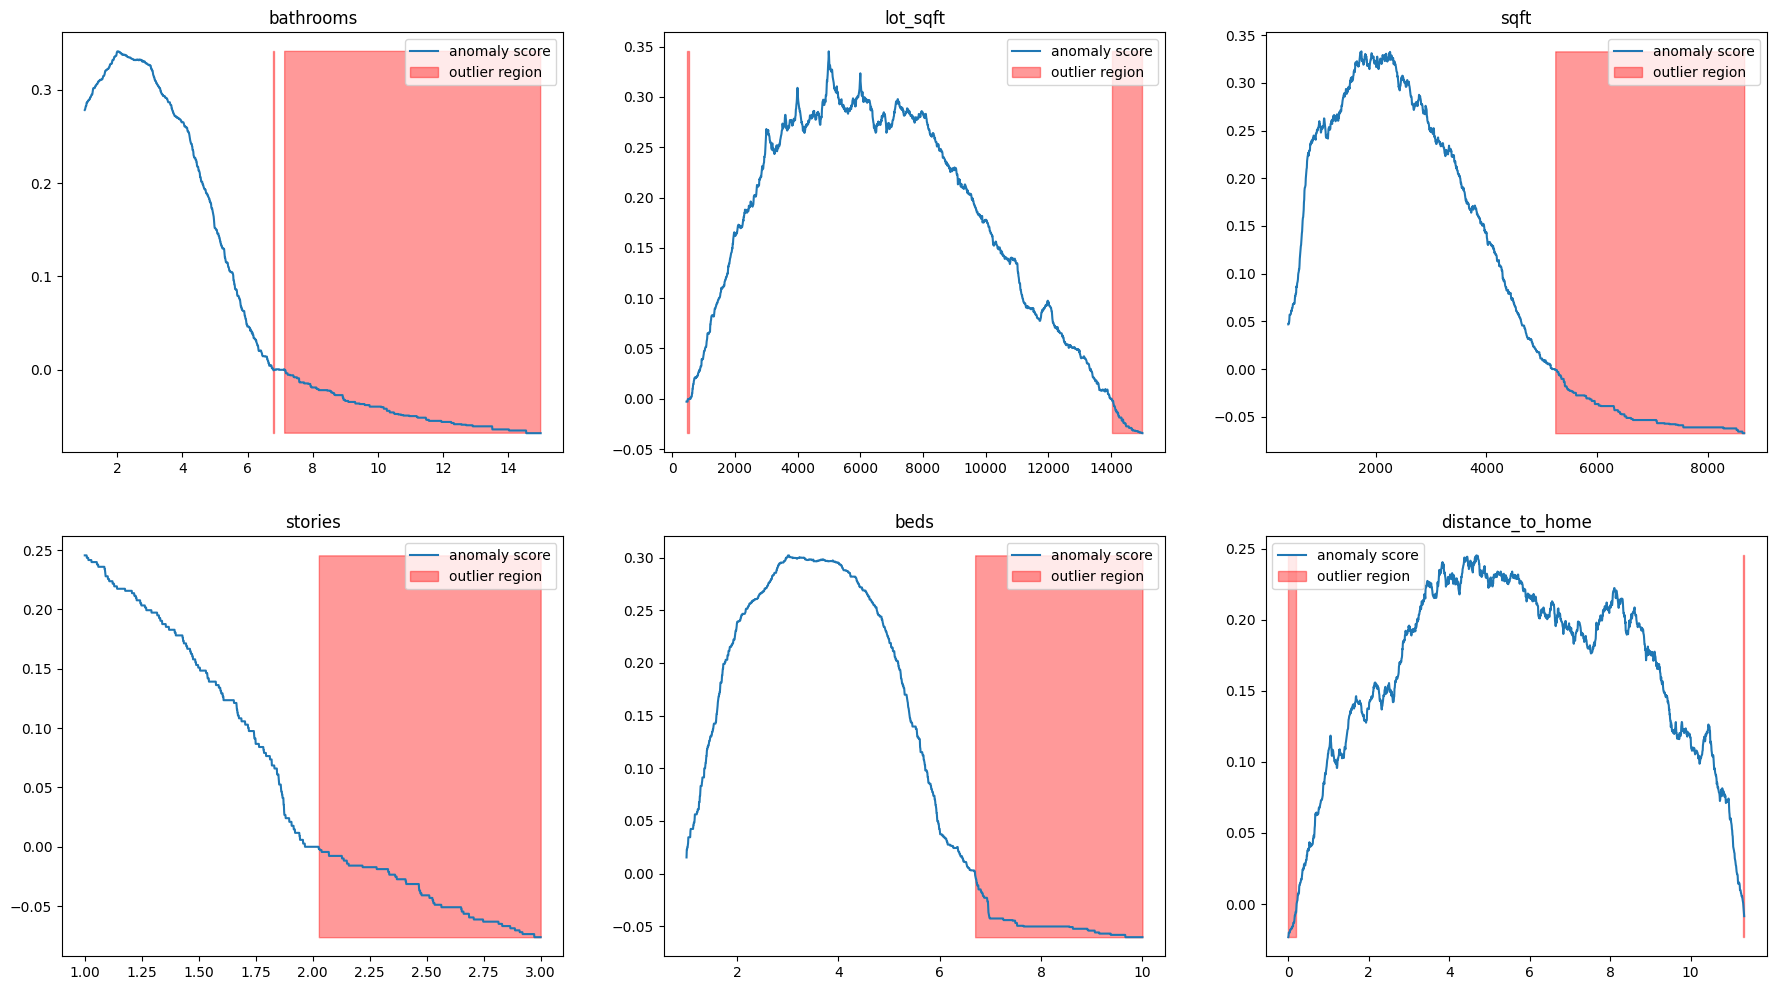

In [42]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

features_analysis = ToDataFrame().fit_transform(fg.features)
features_analysis.dropna(axis=0, inplace=True)
features_analysis['bathrooms'] = features_analysis[['baths_full', 'baths_3qtr', 'baths_half', 'baths_1qtr']].sum(axis=1)

cta = ['bathrooms', 'lot_sqft', 'sqft', 'stories', 'beds', 'distance_to_home']

fig, axs = plt.subplots(2, 3, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

outlier_flags = {}

for i, column in enumerate(cta):
    isolation_forest = IsolationForest(contamination = 0.005)
    isolation_forest.fit(features_analysis[column].values.reshape(-1,1))

    xx = np.linspace(features_analysis[column].min(), features_analysis[column].max(), len(features_analysis)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    outlier_flags[column] = outlier

    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

In [43]:
fa2 = features_analysis.copy()

aggregate = np.zeros_like(fa2.shape[0])
for k, v in outlier_flags.items():
    fa2[f'{k}_outlier'] = v
    aggregate = np.add(aggregate, v)
fa2['agg_outlier'] = aggregate
fa2.head()

,Property_ID,Status,Days_listed,Days_updated,baths_full,baths_3qtr,baths_half,baths_1qtr,year_built,lot_sqft,...,lat,long,bathrooms,bathrooms_outlier,lot_sqft_outlier,sqft_outlier,stories_outlier,beds_outlier,distance_to_home_outlier,agg_outlier
0,2659298958,for_sale,2,2,1,1,0,0,1979,6500,...,47.729440,-122.324938,2,1,-1,1,1,1,-1,2
1,1093027260,for_sale,3,3,2,1,1,0,2012,1975,...,47.587612,-122.309678,4,1,-1,1,1,1,-1,2
2,1648537949,for_sale,3,3,2,0,0,0,1962,7618,...,47.574457,-122.303656,2,1,-1,1,1,1,-1,2
3,1757015623,for_sale,3,3,3,2,0,0,1911,3376,...,47.660596,-122.365015,5,1,-1,1,1,1,-1,2
4,1776112231,for_sale,3,3,3,0,1,0,2017,3774,...,47.687443,-122.354342,4,1,-1,1,1,1,-1,2


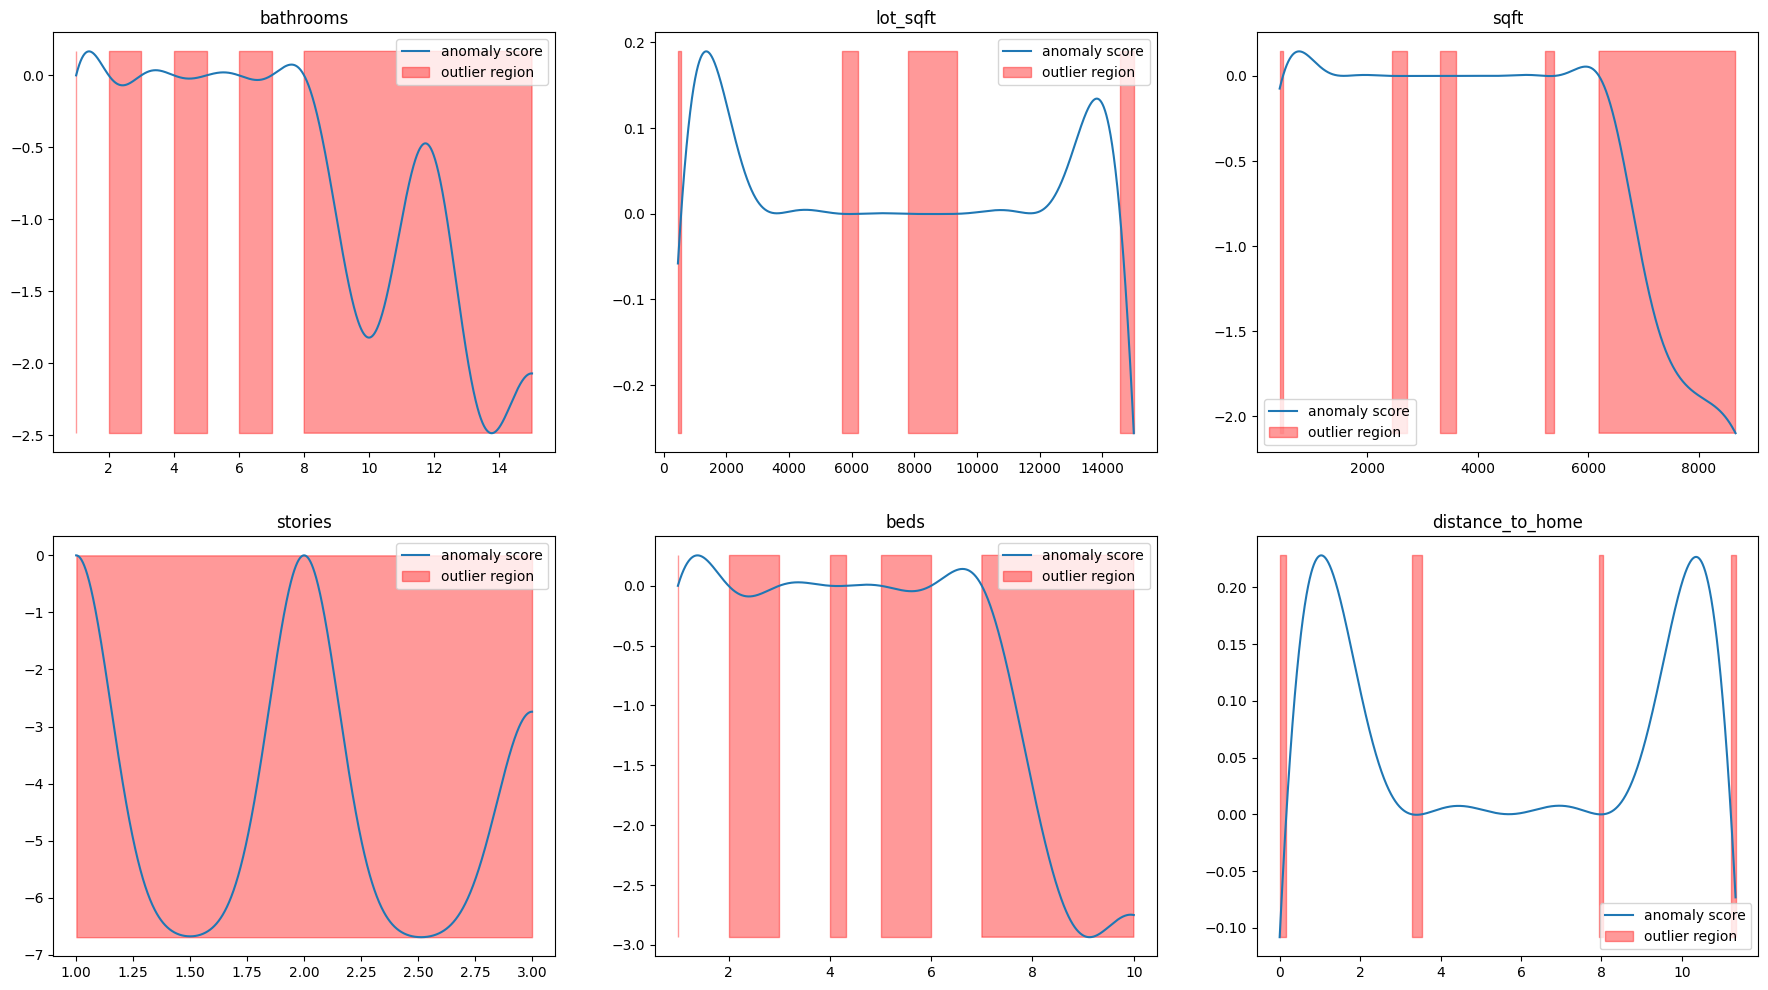

In [44]:
from sklearn.svm import OneClassSVM

features_analysis = ToDataFrame().fit_transform(fg.features)
features_analysis.dropna(axis=0, inplace=True)
features_analysis['bathrooms'] = features_analysis[['baths_full', 'baths_3qtr', 'baths_half', 'baths_1qtr']].sum(axis=1)

cta = ['bathrooms', 'lot_sqft', 'sqft', 'stories', 'beds', 'distance_to_home']

fig, axs = plt.subplots(2, 3, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

outlier_flags = {}

for i, column in enumerate(cta):
    isolation_forest = OneClassSVM(nu=0.01)
    isolation_forest.fit(features_analysis[column].values.reshape(-1,1))

    xx = np.linspace(features_analysis[column].min(), features_analysis[column].max(), len(features_analysis)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    outlier_flags[column] = outlier

    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

In [66]:
import geopandas as gpd
from shapely.geometry import Point

from bokeh.io import output_notebook
output_notebook()

from bokeh.io import show
from bokeh.plotting import gmap
from bokeh.models import GMapOptions
from bokeh.models import ColumnDataSource

%matplotlib inline

google_maps_api_key = keys['GoogleMaps']
bokeh_width, bokeh_height = 500,400

def plot(center_home, zoom=10, map_type='roadmap'):

    #if isinstance(center_home, dict):
    lat = center_home.get('centroid', {}).get('lat')
    lon = center_home.get('centroid', {}).get('lon')

    title = f"{center_home['city']}, {center_home['state_code']}"

    gmap_options = GMapOptions(lat = lat, lng = lon, map_type = map_type, zoom = zoom)
    p = gmap(google_maps_api_key, gmap_options, title=title, width=bokeh_width, height=bokeh_height)
    center = p.circle([lon], [lat], size=10, alpha=0.5, color='red')
    show(p)
    return p

p = plot(user_home, map_type='terrain')

Loading BokehJS ...

In [83]:
my_house = rea.get_UserHome(keys['SampleHouse'])
my_house_details = rea.get_PropertyDetail(my_house['property_id'])
tt = defaultdict(list)
for d in my_house_details['data']['property_detail']['features']:
    tt[f"{d['parent_category']}_{d['category']}"].append(d['text'])